In [1]:
# coding: utf-8
%matplotlib inline
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import csv
import datetime
from sklearn.utils import resample
from sklearn.cross_validation import train_test_split, StratifiedKFold
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, recall_score, precision_recall_fscore_support
from scipy import interp



In [2]:
def strictly_decreasing(L):
    return all(x>y for x, y in zip(L, L[1:]))

In [3]:
filename = 'data/ATA_data.csv'
random_seed = 0
num_samp = 1000000
test_percentage = 0.2
charting = 1

In [4]:
    # need to add seed options, test_percentage, totalData,
    '''
    This function is used to train the probability model, returns pickled model
    '''
    # Setting random seed

    # Loading Dataset and Reordering Data
    df = pd.read_csv(filename)
    df = df.drop('Unnamed: 0', 1)

    ''' Downsampling by a target total samples, due to the large number of
    categorical variables, however the outcome ratio is preserved.'''

    # Dummy variables are created
    y_com, X_com = dmatrices('installed ~ C(hours) + C(device) + C(weekday) +'
                             'C(app_type) + C(country) +C(publisher_name) + C(ad_id)',
                             df, return_type='dataframe')
    y_com = np.ravel(y_com.iloc[:, 1:])

    ''' Downsampling by a target total samples, due to the large number of
    categorical variables, however the outcome ratio is preserved.'''

    X_rsampled, y_rsampled = resample(X_com, y_com, n_samples=num_samp, random_state=random_seed)

    X_train, X_test, y_train, y_test = train_test_split(X_rsampled, y_rsampled,
                                            test_size=test_percentage,
                                            random_state=random_seed)

In [5]:
    ProbModel = LogisticRegression(class_weight='balanced', fit_intercept=False)
    ProbModel.fit(X_train, y_train)
    probLR2 = ProbModel.predict_proba(X_test)
    pranks = range(0, 100, 10)
    pranks = pranks[::-1]
    probability_to_install = probLR2[:, 1]
    Test_df = pd.DataFrame(probability_to_install, columns=['Prob'])
    Test_df['Outcome'] = y_test
    num_of_customers = np.empty((10))
    num_response = np.empty((10))
    response_rate = np.empty((10))
    total_pos_outcomes = Test_df['Outcome'].sum()

In [6]:
Z = ProbModel.predict(X_test)

In [7]:
print classification_report(y_test, Z)

             precision    recall  f1-score   support

        0.0       1.00      0.64      0.78    199898
        1.0       0.00      0.81      0.00       102

avg / total       1.00      0.64      0.78    200000



In [8]:
cm =  confusion_matrix(y_test,Z, labels=[True, False]).transpose()

In [9]:
print cm

[[    83  71841]
 [    19 128057]]


In [10]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=25)
    plt.colorbar()
    tick_marks = [0, 1]
    plt.xticks(tick_marks, ['T', 'F'], rotation=45, fontsize=25)
    plt.yticks(tick_marks, ['T', 'F'], fontsize=25)
    plt.tight_layout()
    plt.ylabel('Truth', fontsize=25)
    plt.xlabel('Prediction', fontsize=25)

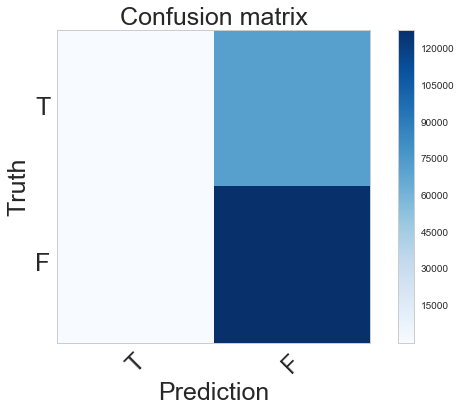

In [11]:
sns.set_style("whitegrid", {'axes.grid' : False})

plot_confusion_matrix(cm)
plt.show()

In [12]:
aa = np.array(X_rsampled)

In [13]:
cv = StratifiedKFold(y_com, n_folds=6)

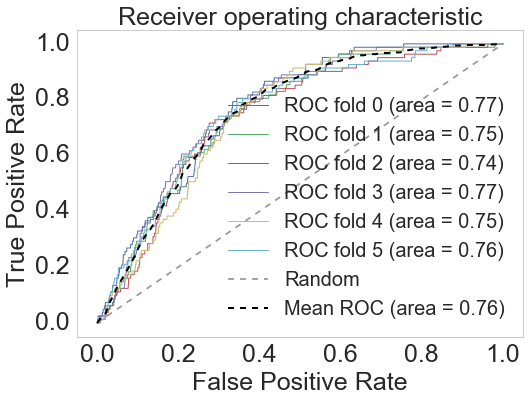

In [14]:
cv = StratifiedKFold(y_rsampled, n_folds=6)
classifier = LogisticRegression(class_weight='balanced', fit_intercept=False)

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in enumerate(cv):
    probas_ = classifier.fit(aa[train], y_rsampled[train]).predict_proba(aa[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y_rsampled[test], probas_[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=25)
plt.ylabel('True Positive Rate', fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.title('Receiver operating characteristic', fontsize=25)
plt.legend(loc="lower right", fontsize=20)
plt.show()

In [15]:
80.0/(67796+80)

0.0011786198361718428

In [16]:
80.0/(67796)*100

0.11800106200955808

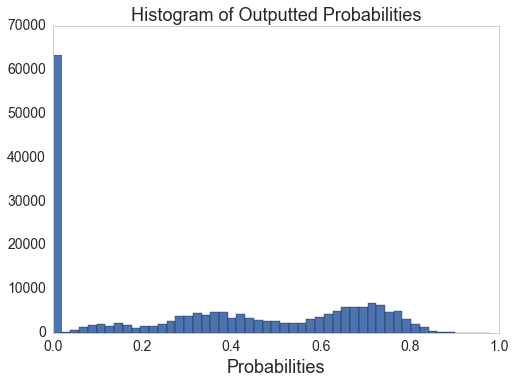

In [17]:
plt.hist(probLR2[:,1], bins = 50)
plt.xlabel('Probabilities', fontsize = 18)
plt.title('Histogram of Outputted Probabilities', fontsize = 18)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.savefig('img/probabilities.png', dpi=200)
plt.show()

In [18]:
rank_percent = (np.array(range(0,100,20))/100.0)[::-1]

In [19]:
rank_percent = np.insert(rank_percent,0, 1)

In [20]:
rank_percent

array([ 1. ,  0.8,  0.6,  0.4,  0.2,  0. ])

In [21]:
def binning(dataframe):
    Num_per_bins = []
    response_per_bins = []
    for i in range(1,len(rank_percent)):
        Num_per_bins.append(dataframe[np.logical_and(dataframe['Prob']< rank_percent[i-1], dataframe['Prob'] > rank_percent[i])].count()['Outcome'])
        response_per_bins.append(dataframe[np.logical_and(dataframe['Prob']< rank_percent[i-1], dataframe['Prob'] > rank_percent[i])].sum()['Outcome'])
    return Num_per_bins, response_per_bins

In [22]:
Num_per_bins = []
response_per_bins = []
for i in range(1,len(rank_percent)):
    Num_per_bins.append(Test_df[np.logical_and(Test_df['Prob']< rank_percent[i-1], Test_df['Prob'] > rank_percent[i])].count()['Outcome'])
    response_per_bins.append(Test_df[np.logical_and(Test_df['Prob']< rank_percent[i-1], Test_df['Prob'] > rank_percent[i])].sum()['Outcome'])

In [23]:
num_bins, response_bins = binning(Test_df)

In [24]:
num_bins

[4981, 53777, 30228, 34846, 76168]

In [25]:
response_bins

[5.0, 69.0, 13.0, 6.0, 9.0]

In [26]:
Num_per_bins

[4981, 53777, 30228, 34846, 76168]

In [27]:
response_per_bins

[5.0, 69.0, 13.0, 6.0, 9.0]

In [28]:
factor = np.array(response_per_bins) / np.array(Num_per_bins)

In [29]:
factor

array([ 0.00100381,  0.00128308,  0.00043006,  0.00017219,  0.00011816])

In [30]:
alphas = []
for i in range(1,len(rank_percent)):
    T = (Test_df[np.logical_and(Test_df['Prob']< rank_percent[i-1], Test_df['Prob'] > rank_percent[i])])
    alphas.append((rank_percent[i-1] - T['Prob'])/(rank_percent[0]- rank_percent[1]))

In [31]:
# Fitting monotonically
fit_reg = IsotonicRegression(y_min= factor[0])

Tfit = (Test_df[np.logical_and(Test_df['Prob']< 1, Test_df['Prob'] > 0.8)])
X_fit = rank_percent[1]- Tfit['Prob']

y_fit = (alphas[0]*factor[1]+(1-alphas[0])*factor[0])

fit_reg.fit(X_fit,y_fit)

a1 = fit_reg.predict(X_fit)

In [86]:
strictly_decreasing(factor)
    

False

In [33]:
response_per_bins

[5.0, 69.0, 13.0, 6.0, 9.0]

In [34]:
a1 = (alphas[0]*factor[1]+(1-alphas[0])*factor[0])

a2 = (alphas[1]*factor[2]+(1-alphas[1])*factor[1])

In [35]:
a3 = (alphas[2]*factor[3]+(1-alphas[2])*factor[2])

a4 = (alphas[3]*factor[4]+(1-alphas[3])*factor[3])

In [36]:
a5 = ((1-alphas[4])*factor[3])

In [37]:
adjusted_prob = np.concatenate((a1,a2,a3,a4,a5))[::-1]

In [38]:
len(adjusted_prob)

200000

In [39]:
len(probLR2[:,1])

200000

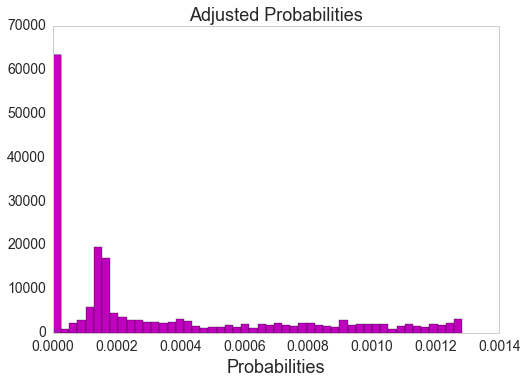

In [40]:
#plt.hist(probLR2[:,1], bins=50, alpha=0.5, label='Logistic Scores' )
plt.hist(adjusted_prob, bins=50, color='m' )

plt.xlabel('Probabilities', fontsize = 18)
plt.title('Adjusted Probabilities', fontsize = 18)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.savefig('img/Adjustedprob.png', dpi=200)
plt.show()

In [85]:
total_response = []
difference = []
pdiff = []
for o in range(0,1000):        
    X_rsampled, y_rsampled = resample(X_com, y_com, n_samples=500000)
    probLR2 = ProbModel.predict_proba(X_rsampled)
    probability_to_install = probLR2[:, 1]
    Test_df2 = pd.DataFrame(probability_to_install, columns=['Prob'])
    Test_df2['Outcome'] = y_rsampled

    alphas2 = []
    for i in range(1,len(rank_percent)):
        T = (Test_df2[np.logical_and(Test_df2['Prob']< rank_percent[i-1], Test_df2['Prob'] > rank_percent[i])])
        alphas2.append((rank_percent[i-1] - T['Prob'])/(rank_percent[0]- rank_percent[1]))

    Num_per_bins2 = []
    response_per_bins2 = []
    for i in range(1,len(rank_percent)):
        Num_per_bins2.append(Test_df2[np.logical_and(Test_df2['Prob']< rank_percent[i-1], Test_df2['Prob'] > rank_percent[i])].count()['Outcome'])
        response_per_bins2.append(Test_df2[np.logical_and(Test_df2['Prob']< rank_percent[i-1], Test_df2['Prob'] > rank_percent[i])].sum()['Outcome'])
    
    a1 = (alphas2[0]*factor[1]+(1-alphas2[0])*factor[0]).sum()
    a2 = (alphas2[1]*factor[2]+(1-alphas2[1])*factor[1]).sum()
    a3 = (alphas2[2]*factor[3]+(1-alphas2[2])*factor[2]).sum()
    a4 = (alphas2[3]*factor[4]+(1-alphas2[3])*factor[3]).sum()
    a5 = ((1-alphas2[4])*factor[4]).sum()
    
    total_response.append(np.array(response_per_bins2).sum())
    difference.append(np.array(response_per_bins2).sum() - (a1+a2+a3+a4+a5)*1.30)
    pdiff.append(difference[o]/total_response[o])

    

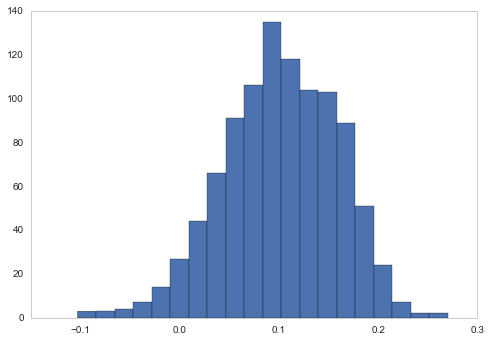

In [87]:
plt.hist(pdiff, bins= 20 )
plt.savefig('img/scaled.png', dpi = 200)

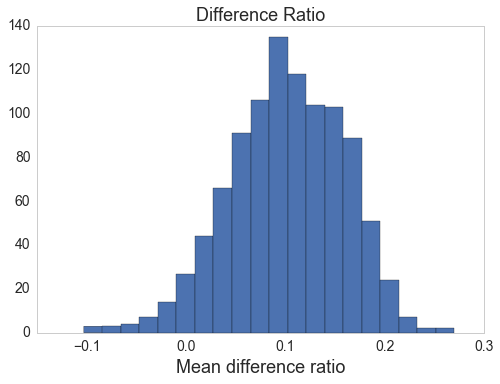

In [88]:
plt.hist(pdiff, bins= 20 )
plt.xlabel('Mean difference ratio', fontsize = 18)
plt.title('Difference Ratio', fontsize = 18)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)



plt.savefig('img/imMeandiff.png', dpi=200)
plt.show()

In [89]:
np.mean(pdiff)

0.10118700400518557

In [90]:
np.std(pdiff)

0.057200620570103118

In [91]:
a = np.array([1, 2, 3])
b = np.array([1, 6])
c = np.array([1, 6])
np.concatenate((a, b,c))

array([1, 2, 3, 1, 6, 1, 6])

In [92]:
df.dtypes

datetime          object
ad_id              int64
app_name          object
app_categories    object
publisher_name    object
os                object
osv                int64
make              object
model             object
country           object
city              object
language          object
impression          bool
clicked             bool
installed           bool
device            object
app_type          object
weekday            int64
hours              int64
week               int64
dtype: object

In [93]:
20.0/48

0.4166666666666667

In [94]:
np.mean(pdiff)

0.10118700400518557

In [95]:
np.std(pdiff)

0.057200620570103118

In [96]:
max(pdiff)

0.27009332705088485

In [97]:
min(pdiff)

-0.10320465648424103

In [98]:
factor2 = factor

In [99]:
factoring = []

In [100]:
factoring.append(factor)

In [101]:
factoring.append(factor2)

In [102]:
a1+a2+a3+a4+a5

167.28843098303074

In [103]:
34+268+106+62+24

494

In [104]:
T1 = Test_df[np.logical_and(Test_df['Prob']< 1, Test_df['Prob'] > 0.80)]

In [105]:
alpha = (1 - T1['Prob'])/(0.2)

In [106]:
T2 = Test_df[np.logical_and(Test_df['Prob']< 0.8, Test_df['Prob'] > 0.60)]

In [107]:
factor[0]

0.0010038144950813091

In [108]:
alpha = (0.8 - T2['Prob'])/(0.2)

In [109]:
alpha

1         0.663556
6         0.352049
9         0.488615
20        0.552659
21        0.923049
22        0.549388
26        0.920506
27        0.301055
30        0.743276
33        0.594172
36        0.586343
39        0.620679
58        0.238821
60        0.463960
61        0.342011
65        0.256168
66        0.521891
68        0.905775
69        0.665055
71        0.375048
75        0.822300
76        0.607285
79        0.661941
87        0.709092
88        0.133216
90        0.810978
94        0.689408
99        0.004514
102       0.540065
106       0.908533
            ...   
199879    0.505963
199880    0.916532
199887    0.571689
199893    0.634649
199894    0.414838
199896    0.321079
199901    0.946992
199905    0.690692
199906    0.787667
199910    0.299368
199914    0.176658
199915    0.846251
199918    0.259854
199935    0.281762
199942    0.842547
199945    0.692599
199948    0.387291
199949    0.558034
199956    0.530421
199959    0.414177
199961    0.308114
199965    0.

In [110]:
(alpha*factor[1] + (1-alpha)*factor[0]).sum()

61.627458148192865

In [112]:
impressions_percent = range(0, 110, 10)
gains_baseline = impressions_percent

Gain_df = pd.DataFrame(num_of_customers, columns=['No. of Impressions'])
Gain_df['No. of Installs'] = num_response
Gain_df['Response Rate'] = response_rate
bin_response = num_response[::-1] - np.roll(num_response[::-1],-1)
bin_response[0] = num_response[0]
Gain_df['bin response'] = bin_response
gains_model = [0]+(list(Gain_df['Response Rate']))
lift = np.round(list(np.array(gains_model)/np.array(impressions_percent)), 1)
lift[0] = 1

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in divide
  # This is added back by InteractiveShellApp.init_path()


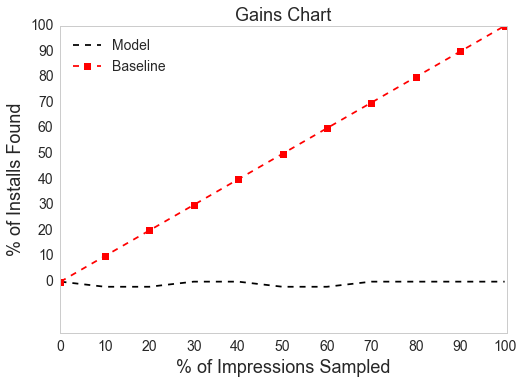

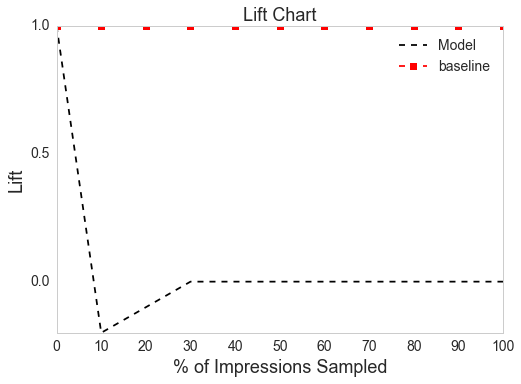

In [113]:
# Gains plot
plt.plot(impressions_percent, gains_model, '--', color=(0, 0, 0),
         label='Mean')
plt.plot(impressions_percent, gains_baseline, 'rs--')
plt.xlim([0, 100.5])
plt.xlabel('% of Impressions Sampled', fontsize=18)
plt.ylabel('% of Installs Found', fontsize=18)
plt.title('Gains Chart', fontsize=18)
plt.xticks(impressions_percent, impressions_percent, fontsize=14)
plt.yticks(gains_baseline, gains_baseline, fontsize=14)
plt.legend(['Model', 'Baseline'], fontsize=14, loc=0)
plt.show()

# Lift plot
plt.plot(gains_baseline, lift, '--', color=(0, 0, 0),
         label='Mean')
plt.plot(gains_baseline, np.ones(11), 'rs--')
plt.xlabel('% of Impressions Sampled', fontsize=18)
plt.ylabel('Lift', fontsize=18)
plt.title('Lift Chart', fontsize=18)
plt.xticks(impressions_percent, impressions_percent, fontsize=14)
plt.yticks(np.arange(0, max(lift)+0.5, 0.5), np.arange(0, max(lift)+0.5,
           0.5), fontsize=14)
plt.legend(['Model', 'baseline'], fontsize=14)
plt.show()

In [68]:
Gain_df

,No. of Impressions,No. of Installs,Response Rate,bin response
0,-2.000000e+00,-2.000000e+00,-2.000000e+00,-2.000000e+00
1,-1.730597e-77,-2.000000e+00,-2.000000e+00,2.228088e-314
2,2.205145e-314,2.205145e-314,2.205145e-314,-6.932840e-310
3,6.932837e-310,6.932837e-310,6.932837e-310,2.000000e+00
4,-2.000000e+00,-2.000000e+00,-2.000000e+00,0.000000e+00
5,-2.000000e+00,-2.000000e+00,-2.000000e+00,-2.000000e+00
6,-2.000000e+00,6.932840e-310,2.425550e-314,6.932617e-310
7,-1.730597e-77,0.000000e+00,2.255296e-314,2.000000e+00
8,-3.111083e+231,2.228088e-314,2.255444e-314,0.000000e+00
9,6.953356e-309,6.953356e-309,2.392118e-314,-2.000000e+00
